# NiSpace API test: integrated imaging data

In [1]:
import sys
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# current path
wd = pathlib.Path().resolve().parent
print(wd)

# import nispace
sys.path.append(os.path.dirname(os.path.join(wd, "nispace")))
from nispace import NiSpace
from nispace.datasets import fetch_reference, fetch_example

/Users/llotter/projects/nispace


## Fetch the ABIDE I example dataset

In [2]:
abide_data, abide_pheno = fetch_example("abide")
abide_pheno = abide_pheno.set_index("subject")
display(abide_pheno.shape, abide_pheno.head(5))
display(abide_data.shape, abide_data.head(5))

abide_groups = abide_pheno.dx.map({"ASD": 0, "CTRL": 1}).to_list()

INFO | 28/05/24 08:45:01 | nispace: Loading example dataset: abide
INFO | 28/05/24 08:45:01 | nispace: The abide dataset was parcellated using the Schaefer200MelbourneS1 parcellation.
INFO | 28/05/24 08:45:01 | nispace: Returning parcellated and associated subject data.


(871, 18)

,site,site_num,dx,dx_num,dsm_iv_tr,age,sex,sex_num,qc_rater_1,qc_func_rater_2,qc_func_rater_3,adi_r_social_total_a,adi_r_verbal_total_bv,adi_rrb_total_c,ados_total,srs_raw_total,scq_total,aq_total
subject,,,,,,,,,,,,,,,,,,
50003,PITT,9,ASD,1,1.0,24.45,M,1,OK,OK,OK,27.0,22.0,5.0,13.0,NaN,NaN,NaN
50004,PITT,9,ASD,1,1.0,19.09,M,1,OK,OK,OK,19.0,12.0,5.0,18.0,NaN,NaN,NaN
50005,PITT,9,ASD,1,1.0,13.73,F,2,OK,maybe,OK,23.0,19.0,3.0,12.0,NaN,NaN,NaN
50006,PITT,9,ASD,1,1.0,13.37,M,1,OK,maybe,OK,13.0,10.0,4.0,12.0,NaN,NaN,NaN
50007,PITT,9,ASD,1,1.0,17.78,M,1,OK,maybe,OK,21.0,14.0,9.0,17.0,NaN,NaN,NaN


(871, 216)

,1_RH_SC_HIP,2_RH_SC_AMY,3_RH_SC_pTHA,4_RH_SC_aTHA,5_RH_SC_NAc,6_RH_SC_GP,7_RH_SC_PUT,8_RH_SC_CAU,9_LH_SC_HIP,10_LH_SC_AMY,...,207_RH_CX_Default,208_RH_CX_Default,209_RH_CX_Default,210_RH_CX_Default,211_RH_CX_Default,212_RH_CX_Default,213_RH_CX_Default,214_RH_CX_Default,215_RH_CX_Default,216_RH_CX_Default
subject,,,,,,,,,,,,,,,,,,,,,
50003,0.550379,0.556799,0.558175,0.565839,0.553342,0.519940,0.538905,0.553295,0.545913,0.554257,...,0.511879,0.546551,0.572870,0.489960,0.481450,0.548910,0.553655,0.630450,0.624178,0.629993
50004,0.492533,0.488670,0.497226,0.506997,0.523376,0.498707,0.508254,0.535091,0.502559,0.493528,...,0.499219,0.514022,0.495265,0.535245,0.531300,0.530919,0.544821,0.531825,0.549992,0.583247
50005,0.510875,0.521592,0.522103,0.541097,0.559628,0.521452,0.541922,0.568454,0.529922,0.523470,...,0.539904,0.570698,0.539725,0.570238,0.521150,0.535021,0.549574,0.590597,0.604462,0.599347
50006,0.528309,0.517852,0.529154,0.524831,0.531129,0.517577,0.520542,0.530846,0.522528,0.523406,...,0.553780,0.543042,0.518454,0.561790,0.522045,0.552814,0.528958,0.580796,0.581530,0.590443
50007,0.552136,0.558819,0.555877,0.571004,0.583195,0.536471,0.572627,0.581086,0.541815,0.538237,...,0.584967,0.598638,0.561605,0.603095,0.533502,0.589898,0.550674,0.575307,0.609521,0.621164


## TL;DR

Alright, here we go:

In [3]:
# ...

## The long way

### Fetch PET data

In [4]:
pet_data = fetch_reference("pet", collection="UniqueTracerSets", parcellation="Schaefer200MelbourneS1",
                           print_references=False)
display(pet_data.shape, pet_data.head(2))

INFO | 28/05/24 08:45:01 | nispace: Loading pet maps.
INFO | 28/05/24 08:45:01 | nispace: Applying collection filter from: /Users/llotter/nispace-data/reference/pet/collection-UniqueTracerSets.csv.
INFO | 28/05/24 08:45:01 | nispace: Loading parcellated data: Schaefer200MelbourneS1
INFO | 28/05/24 08:45:01 | nispace: Standardizing parcellated data.


(37, 216)

,,,1_RH_SC_HIP,2_RH_SC_AMY,3_RH_SC_pTHA,4_RH_SC_aTHA,5_RH_SC_NAc,6_RH_SC_GP,7_RH_SC_PUT,8_RH_SC_CAU,9_LH_SC_HIP,10_LH_SC_AMY,...,207_RH_CX_Default,208_RH_CX_Default,209_RH_CX_Default,210_RH_CX_Default,211_RH_CX_Default,212_RH_CX_Default,213_RH_CX_Default,214_RH_CX_Default,215_RH_CX_Default,216_RH_CX_Default
set,map,weight,,,,,,,,,,,,,,,,,,,,,
5HT1a,target-5HT1a_tracer-cumi101_n-8_dx-hc_pub-beliveau2017,8,2.394822,0.039811,-2.307718,-2.278208,-1.617285,-2.915209,-2.141156,NaN,2.317779,0.113038,...,0.860169,0.902825,0.069918,0.294537,-0.004247,-0.019768,-0.290278,-0.543331,-0.149520,-0.333811
5HT1b,target-5HT1b_tracer-p943_n-23_dx-hc_pub-savli2012,23,-2.486676,-2.165188,-1.974889,-2.077337,0.837703,-0.481374,-0.265538,-1.391284,-2.375382,-1.921886,...,0.084217,-0.070527,-1.530903,1.154598,0.863252,1.017385,0.571081,-0.723756,0.490491,0.224721


### Initialize NiSpace

In [5]:
nsp = NiSpace(
    x=pet_data,
    y=abide_data,
    z="gm",
    parcellation="Schaefer200MelbourneS1",
    standardize="xz",
    n_proc=-1,
).fit()

INFO | 28/05/24 08:45:01 | nispace: *** NiSpace.fit() - Data extraction and preparation. ***
INFO | 28/05/24 08:45:01 | nispace: Loading parcellation: Schaefer200MelbourneS1 (n: 216, space: mni152, res: 1mm)
INFO | 28/05/24 08:45:01 | nispace: Loaded integrated parcellation with pre-calculated distance matrix: /Users/llotter/nispace-data/parcellation/parc-Schaefer200MelbourneS1_n-216_space-mni152_res-1mm.nii.gz.
INFO | 28/05/24 08:45:01 | nispace: Checking input data for 'x' (should be, e.g., PET data):
INFO | 28/05/24 08:45:01 | nispace: Input type: DataFrame, assuming parcellated data with shape (n_files/subjects/etc, n_parcels).
WARNING | 28/05/24 08:45:01 | nispace: Parcellated data contains nan values!
INFO | 28/05/24 08:45:01 | nispace: Got 'x' data for 37 x 216 parcels.
INFO | 28/05/24 08:45:01 | nispace: Checking input data for 'y' (should be, e.g., subject data):
INFO | 28/05/24 08:45:01 | nispace: Input type: DataFrame, assuming parcellated data with shape (n_files/subjects/e

Parcellating (-1 proc):   0%|          | 0/1 [00:00<?, ?it/s]

INFO | 28/05/24 08:45:06 | nispace: Combined across images, 0 parcels had only background intensity and were set to nan (indices: []).
INFO | 28/05/24 08:45:06 | nispace: Got 'z' data for 1 x 216 parcels.
INFO | 28/05/24 08:45:06 | nispace: Z-standardizing 'X' data.
INFO | 28/05/24 08:45:06 | nispace: Z-standardizing 'Z' data.


In [6]:
X_reduction = "mean"
nsp.reduce_x("mean", mean_by_set=True, weighted_mean=True)

INFO | 28/05/24 08:45:06 | nispace: *** NiSpace.reduce_x() - X dimensionality reduction. ***
INFO | 28/05/24 08:45:06 | nispace: Calculating parcelwise weighted mean by set of X data.


,1_RH_SC_HIP,2_RH_SC_AMY,3_RH_SC_pTHA,4_RH_SC_aTHA,5_RH_SC_NAc,6_RH_SC_GP,7_RH_SC_PUT,8_RH_SC_CAU,9_LH_SC_HIP,10_LH_SC_AMY,...,207_RH_CX_Default,208_RH_CX_Default,209_RH_CX_Default,210_RH_CX_Default,211_RH_CX_Default,212_RH_CX_Default,213_RH_CX_Default,214_RH_CX_Default,215_RH_CX_Default,216_RH_CX_Default
map,,,,,,,,,,,,,,,,,,,,,
5HT1a,2.394822,0.039811,-2.307718,-2.278208,-1.617285,-2.915209,-2.141156,NaN,2.317779,0.113038,...,0.860169,0.902825,0.069918,0.294537,-0.004247,-0.019768,-0.290278,-0.543331,-0.149520,-0.333811
5HT1b,-1.963548,-0.802376,-1.757439,-1.765235,1.338328,3.118475,0.299013,-1.558383,-2.130793,-0.843973,...,0.389751,0.595694,-0.791068,0.534661,0.063995,1.355606,0.481956,-1.061375,0.268149,0.252180
5HT2a,-2.543451,-2.509070,-3.168597,-2.754982,-2.769800,-3.361826,-2.948179,-3.468156,-2.292785,-2.314988,...,0.370090,-0.012143,-1.086984,0.458058,0.620397,0.675806,0.539532,-0.001042,0.933935,0.476362
5HT4,-0.526438,-0.849203,-1.139770,-1.216924,3.322422,3.526097,5.689232,3.779619,-0.336000,-0.687939,...,0.130975,-0.043807,-0.649666,-0.111675,-0.172678,-0.239773,-0.351591,-0.167115,0.295151,0.110784
5HT6,-0.810784,-1.075617,-1.705566,-1.715799,3.069726,0.908041,4.258488,3.768146,-1.152713,-1.106183,...,0.318943,0.761461,-0.690174,0.176454,-0.653254,0.646419,-0.115689,-0.342631,0.824476,1.306038
5HTT,-0.165535,1.646092,4.406843,3.261086,3.067206,3.828540,3.710339,1.010617,0.044069,2.092643,...,0.110971,0.264044,0.555946,-0.547783,-0.773820,-0.747543,-0.870915,0.064863,0.036592,-0.472418
A4B2,-0.171052,-0.394915,5.192632,7.297688,1.085413,0.402832,0.939368,0.717046,-0.186475,-0.504159,...,-0.046499,-0.036255,-0.579274,0.160981,0.026472,0.682949,0.252711,-0.435623,0.294895,0.346854
CB1,0.380698,0.900730,-2.328007,-2.612950,1.062316,3.389982,1.937658,-1.627931,0.248089,1.084948,...,1.522093,1.490303,0.055502,0.872355,-0.059162,0.503632,-0.247499,-1.606239,-0.255826,0.295454
CBF,-1.079874,-1.628907,-1.107440,-1.126905,-0.245558,-4.009216,-0.888478,-0.610351,-1.273199,-1.759350,...,0.295558,0.208325,-0.366039,0.202064,0.083647,1.738482,1.377039,-0.611710,1.766993,1.067143


### Clean the data

In [7]:
nsp.clean_y(
    how=["between", "within"],
    covariates_between=abide_pheno[["age", "sex_num", "site_num", "dx_num"]] \
        .rename(columns={"site_num": "site"}),
    covariates_within="z",
    combat=True,
    combat_keep="dx_num"
)

INFO | 28/05/24 08:45:06 | nispace: *** NiSpace.clean_y() - Y covariate regression. ***
INFO | 28/05/24 08:45:06 | nispace: Performing covariate regression within map/subjects (e.g., grey matter maps).
INFO | 28/05/24 08:45:06 | nispace: Using Z data for 'within' covariate regression.


Regressing within covariate(s) on Y (-1 proc):   0%|          | 0/871 [00:00<?, ?it/s]

INFO | 28/05/24 08:45:12 | nispace: Performing covariate regression between maps/subjects (e.g., age, sex, site).
INFO | 28/05/24 08:45:12 | nispace: Assuming 4 'between' covariate(s) for 871 maps/subjects.


Regressing 2 between covariate(s) on Y (-1 proc):   0%|          | 0/216 [00:00<?, ?it/s]

INFO | 28/05/24 08:45:13 | nispace: Performing combat harmonization, retaining 1 covariates.
WARNING | 28/05/24 08:45:13 | nispace: Detected missing values in Y data, which is not supported with ComBat harmonization. Missing values will be imputed with map-wise medians and replaced by nan after harmonization. CAVE: experimental feature!


,1_RH_SC_HIP,2_RH_SC_AMY,3_RH_SC_pTHA,4_RH_SC_aTHA,5_RH_SC_NAc,6_RH_SC_GP,7_RH_SC_PUT,8_RH_SC_CAU,9_LH_SC_HIP,10_LH_SC_AMY,...,207_RH_CX_Default,208_RH_CX_Default,209_RH_CX_Default,210_RH_CX_Default,211_RH_CX_Default,212_RH_CX_Default,213_RH_CX_Default,214_RH_CX_Default,215_RH_CX_Default,216_RH_CX_Default
subject,,,,,,,,,,,,,,,,,,,,,
50003,-0.000338,0.005819,0.005393,0.004555,-0.013715,-0.006450,-0.016393,-0.022655,-0.006650,0.002809,...,-0.021474,-0.037950,0.023033,-0.083662,-0.068480,-0.019655,-0.008981,0.021437,0.019712,0.009976
50004,-0.007438,-0.010792,-0.018084,-0.013914,0.015113,-0.015143,-0.007341,0.012218,0.008389,-0.002584,...,0.014216,-0.018567,-0.027604,0.001818,0.009435,0.001682,0.021410,-0.020426,-0.012523,0.011121
50005,-0.020725,-0.015213,-0.013424,-0.004522,0.012044,0.012832,0.004166,0.007626,0.000800,-0.011338,...,0.023795,0.010905,0.000071,0.011841,-0.013591,-0.016123,0.006252,0.005213,0.015855,-0.002235
50006,0.004723,-0.009967,-0.003984,-0.019345,-0.008008,-0.007764,-0.016725,-0.018523,0.001515,0.000595,...,0.040400,-0.014438,-0.024546,0.001161,-0.019017,0.001277,-0.018637,0.002874,-0.003153,-0.007523
50007,-0.010982,-0.007656,-0.012802,-0.005289,0.006976,-0.011875,0.003626,-0.006452,-0.024134,-0.034459,...,0.041066,0.007589,-0.010110,0.009904,-0.037094,0.008002,-0.029020,-0.037807,-0.014613,-0.014937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51583,0.010361,-0.002659,0.017697,0.017996,0.016941,0.047137,0.025722,0.029940,0.011350,0.002409,...,0.004107,-0.000792,0.027131,0.022165,0.004975,0.015357,-0.006639,-0.016625,-0.016314,-0.003973
51584,-0.035672,-0.001344,-0.031380,-0.027576,-0.007359,-0.054236,-0.027259,-0.014558,-0.020007,0.006024,...,-0.001368,-0.035370,-0.052380,-0.020875,-0.030903,-0.043986,-0.025204,0.010735,0.005271,-0.009094
51585,0.004589,-0.014223,0.054034,0.049606,-0.011577,0.051913,0.017593,-0.000801,-0.011647,-0.021683,...,0.022157,0.019613,0.039288,0.009685,0.003823,0.018134,0.009082,-0.003248,-0.014317,0.012335


### Run group comarison

In [8]:
comparison = "zscore(a,b)"
res = nsp.transform_y(
    comparison,
    groups=abide_groups
)
res

INFO | 28/05/24 08:45:13 | nispace: *** NiSpace.transform_y() - Y transformation and comparison. ***
INFO | 28/05/24 08:45:13 | nispace: Groups/sessions vector provided, ensuring dummy-coding.
INFO | 28/05/24 08:45:13 | nispace: Applying Y transform 'zscore(a,b)'.


,1_RH_SC_HIP,2_RH_SC_AMY,3_RH_SC_pTHA,4_RH_SC_aTHA,5_RH_SC_NAc,6_RH_SC_GP,7_RH_SC_PUT,8_RH_SC_CAU,9_LH_SC_HIP,10_LH_SC_AMY,...,207_RH_CX_Default,208_RH_CX_Default,209_RH_CX_Default,210_RH_CX_Default,211_RH_CX_Default,212_RH_CX_Default,213_RH_CX_Default,214_RH_CX_Default,215_RH_CX_Default,216_RH_CX_Default
subject,,,,,,,,,,,,,,,,,,,,,
50003,-0.031433,0.305133,0.348931,0.311167,-0.818024,-0.164155,-1.228602,-1.731521,-0.600716,0.194346,...,-0.841693,-2.635538,1.054293,-4.321579,-3.217182,-1.236678,-0.446953,1.413307,1.241340,0.528810
50004,-0.578013,-0.532814,-1.027820,-0.959344,0.871314,-0.456628,-0.520168,0.900425,0.681915,-0.124869,...,0.561647,-1.301247,-1.176789,0.096118,0.505409,0.172285,1.252370,-1.432693,-0.911167,0.593411
50005,-1.600940,-0.755856,-0.754533,-0.313239,0.691451,0.484604,0.380287,0.553827,0.034698,-0.642898,...,0.938329,0.727522,0.042577,0.614077,-0.594731,-1.003407,0.404796,0.310348,0.983738,-0.160232
50006,0.358182,-0.491220,-0.200987,-1.332931,-0.483589,-0.208350,-1.254594,-1.419635,0.095638,0.063291,...,1.591231,-1.017048,-1.042047,0.062178,-0.853949,0.145578,-0.986848,0.151297,-0.285505,-0.458621
50007,-0.850876,-0.374641,-0.718061,-0.366008,0.394439,-0.346679,0.338053,-0.508664,-2.091845,-2.011276,...,1.617407,0.499260,-0.405982,0.514007,-1.717637,0.589608,-1.567407,-2.614304,-1.050697,-0.876952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51583,0.792271,-0.122542,1.070440,1.235756,0.978443,1.638801,2.067271,2.237946,0.934478,0.170669,...,0.164145,-0.077709,1.234848,1.147628,0.292304,1.075323,-0.315988,-1.174287,-1.164310,-0.258270
51584,-2.751563,-0.056213,-1.807503,-1.899105,-0.445585,-1.771895,-2.078998,-1.120441,-1.739919,0.384602,...,-0.051142,-2.457937,-2.268394,-1.076673,-1.421829,-2.843333,-1.354052,0.685730,0.277000,-0.547275
51585,0.347850,-0.705904,3.201283,3.410115,-0.692731,1.799489,1.431145,-0.082158,-1.026894,-1.255183,...,0.873915,1.326909,1.770484,0.502671,0.237281,1.258698,0.563043,-0.264903,-1.030956,0.661919


### Run colocalization 

In [9]:
colocalizations_dict = nsp.colocalize(
    "spearman",
    Y_transform=comparison,
    X_reduction_method=X_reduction
)
colocalizations_dict.keys()



INFO | 28/05/24 08:45:13 | nispace: *** NiSpace.colocalize() - Estimating X & Y colocalizations. ***
INFO | 28/05/24 08:45:13 | nispace: Will regress Z from Y before colocalization calculation.
WARNING | 28/05/24 08:45:13 | nispace: It seems, Z regression was performed using NiSpace.clean_y(). Will not perform Z regression.


Colocalizing (spearman, -1 proc):   0%|          | 0/403 [00:00<?, ?it/s]

dict_keys(['rho'])

### Run permutation

In [10]:
_ = nsp.permute(
    "groups",
    "spearman",
    Y_transform=comparison,
    X_reduction_method=X_reduction,
    n_perm=1000,
    groups_perm_strategy="prop"
)

INFO | 28/05/24 08:45:15 | nispace: *** NiSpace.permute() - Estimate exact non-parametric p values. ***
INFO | 28/05/24 08:45:15 | nispace: Permuting Y groups.
INFO | 28/05/24 08:45:15 | nispace: Loading dimensionality-reduced X data, reduction method = 'mean'.
INFO | 28/05/24 08:45:15 | nispace: Loading transformed Y data, transform = 'zscore(a,b)'.
INFO | 28/05/24 08:45:15 | nispace: Will calculate p values for mean calculation across Y maps. Set 'p_from_average_y_coloc' to False to change this behavior.
INFO | 28/05/24 08:45:15 | nispace: Loading observed colocalizations (method = 'spearman').
INFO | 28/05/24 08:45:15 | nispace: Generating permuted Y groups.
INFO | 28/05/24 08:45:15 | nispace: Permuting groups/sessions vector, strategy: unpaired, prop.


Permuting groups (-1 proc):   0%|          | 0/1000 [00:00<?, ?it/s]

Null transformations (spearman, -1 proc):   0%|          | 0/1000 [00:00<?, ?it/s]

Null colocalizations (spearman, -1 proc):   0%|          | 0/1000 [00:00<?, ?it/s]

INFO | 28/05/24 08:45:50 | nispace: Calculating exact p-values (tails = {'rho': 'two'}).


In [11]:
nsp._p_colocs.keys()

dict_keys(['xdimred-mean_ytrans-zscore(a,b)_coloc-spearman_stat-rho_perm-groups_norm-false_mc-none', 'xdimred-mean_ytrans-zscore(a,b)_coloc-spearman_stat-rho_perm-groups_norm-true_mc-none'])

INFO | 28/05/24 08:45:50 | nispace: *** NiSpace.plot() - Plot colocalization results. ***
ERROR | 28/05/24 08:45:50 | nispace: No p values found. Provide via 'p_dict' or run NiSpace.permute()!
ERROR | 28/05/24 08:45:50 | nispace: No corrected p values for mc_method 'fdr_bh' found. Provide via 'pc_dict' or run NiSpace.permute() & NiSpace.correct_p()!
INFO | 28/05/24 08:45:50 | nispace: Creating categorical plot for method spearman, colocalization stat rho.


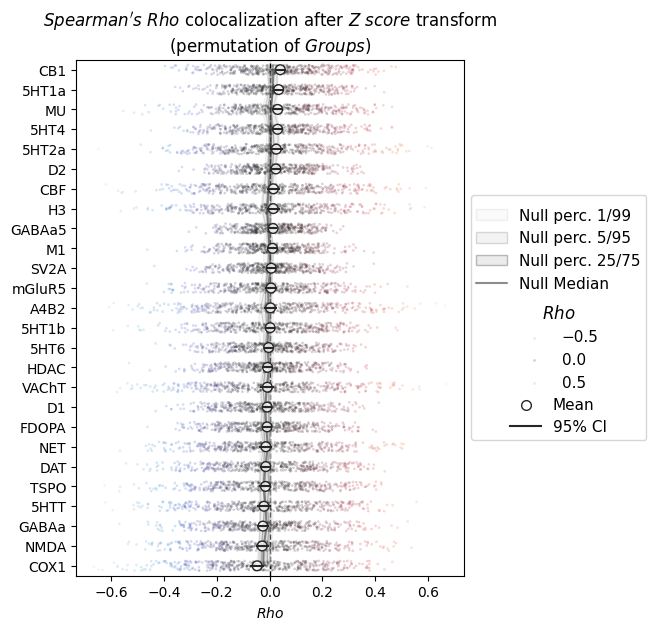

{'xdimred-mean_ytrans-zscore(a,b)_coloc-spearman_stat-rho_perm-groups_norm-false_mc-none': map   5HT1a  5HT1b  5HT2a   5HT4  5HT6   5HTT   A4B2    CB1    CBF   COX1  \
 mean  0.001  0.436   0.16  0.112  0.63  0.468  0.748  0.001  0.048  0.032   
 
 map   ...     H3   HDAC     M1     MU   NET  NMDA   SV2A  TSPO  VAChT  mGluR5  
 mean  ...  0.016  0.614  0.256  0.001  0.82  0.58  0.256  0.87  0.988   0.176  
 
 [1 rows x 26 columns],
 'xdimred-mean_ytrans-zscore(a,b)_coloc-spearman_stat-rho_perm-groups_norm-true_mc-none': map      5HT1a     5HT1b    5HT2a     5HT4      5HT6      5HTT      A4B2  \
 mean  0.006553  0.457278  0.15656  0.04908  0.505828  0.612218  0.423791   
 
 map      CB1       CBF      COX1  ...        H3      HDAC        M1        MU  \
 mean  0.0053  0.167546  0.081939  ...  0.072216  0.730417  0.211951  0.014454   
 
 map        NET      NMDA      SV2A      TSPO     VAChT    mGluR5  
 mean  0.692965  0.590048  0.428042  0.947564  0.645376  0.218801  
 
 [1 rows x 26 c

In [12]:
nsp.plot(method="spearman", 
         Y_transform=comparison,
         X_reduction_method=X_reduction,
         plot_kwargs={"sort_categories": True},
         permute_what="groups")

nsp._p_colocs